<a href="https://colab.research.google.com/github/harishmuh/machine_learning_practices/blob/main/feature_selection_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### `Feature Selection`

**Definition**: Feature Selection is the process of selecting a subset of relevant features for use in machine learning model building.

It is not always the truth that the more data, the better the result will be. Including irrelevant features (the ones that are just unhelpful to the prediction) and redundant features (irrelevant in the presence of others) will only make the learning process overwhelmed and easy to cause overfitting.

With feature selection, we can have:

- simplification of models to make them easier to interpret
- shorter training times and lesser computational cost
- lesser cost in data collection
- avoid the curse of dimensionality
- enhanced generalization by reducing overfitting

We should keep in mind that different feature subsets render optimal performance for different algorithms. So it's not a separate process along with the machine learning model training. Therefore, if we are selecting features for a linear model, it is better to use selection procedures targeted to those models, like importance by regression coefficient or Lasso. And if we are selecting features for trees, it is better to use tree derived importance.

#### **Univariate Statistic Feature Selection / Filter Method**

Filter methods select features based on a performance measure regardless of the ML algorithm later employed.

Univariate filters evaluate and rank a single feature according to a certain criteria, while multivariate filters evaluate the entire feature space. Filter methods are:

- selecting variable regardless of the model
- less computationally expensive
- usually give lower prediction performance

As a result, filter methods are suited for a first step quick screen and removal of irrelevant features.

| **Method** | **Definition** |
| --- | --- |
| Correlation | remove features that are highly correlated with each other |
| Chi-Square | 	Compute chi-squared stats between each non-negative feature and class |
| Mutual Information Filter | Mutual information measures how much information the presence/absence of a feature contributes to making the correct prediction on Y. |

**Note:** One thing to keep in mind when using chi-square test or univariate selection methods, is that in very big datasets, most of the features will show a small p_value, and therefore look like they are highly predictive. This is in fact an effect of the sample size. So care should be taken when selecting features using these procedures. An ultra tiny p_value does not highlight an ultra-important feature, it rather indicates that the dataset contains too many samples.

**Note:** Correlated features do not necessarily affect model performance (trees, etc), but high dimensionality does and too many features hurt model interpretability. So it's always better to reduce correlated features.

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()

data = pd.DataFrame(np.c_[data['data'], data['target']], columns=np.append(data['feature_names'], ['target']))
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [3]:
from sklearn.model_selection import train_test_split

# Define features and target
X = data.drop(columns=['target'])
y = data['target']

# Data splitting # for classification cases use stratify=y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

X_train.shape, X_test.shape

((455, 30), (114, 30))

> Correlation

In [4]:
threshold = 0.5

correlation = X.corr()
correlation = correlation.abs().unstack()
correlation = correlation.sort_values(ascending=False)
correlation = correlation[correlation < 1]
correlation = correlation[correlation > threshold]
correlation = pd.DataFrame(correlation).reset_index()
correlation.columns = ['features1', 'features2', 'corr']
correlation

grouped_feature_ls = []
correlated_group = []

for feature in correlation['features1'].unique():
    if feature not in grouped_feature_ls:

        correlated_block = correlation[correlation['features1']==feature]
        grouped_feature_ls = grouped_feature_ls +  list(correlated_block['features2'].unique()) + [feature]

        correlated_group.append(grouped_feature_ls)

correlated_block

,features1,features2,corr
81,fractal dimension error,compactness error,0.803269
124,fractal dimension error,concavity error,0.727372
157,fractal dimension error,mean fractal dimension,0.688132
202,fractal dimension error,concave points error,0.611044
208,fractal dimension error,worst fractal dimension,0.591328
279,fractal dimension error,mean compactness,0.507318


> Mutual Information Filter

- SelectPercentile: Select features based on percentile of the highest scores.
- SelectKBest: Select features according to the k highest scores.

score:
- mutual_info_classif: Mutual information for a discrete target (classification)
- mutual_info_regression: Mutual information for a continuous target (regression)

In [5]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectPercentile, SelectKBest

def mutual_info(X, y, select_value=10):
    if select_value > 1:
        selector = SelectKBest(mutual_info_classif, k=select_value).fit(X, y)
        col = X.columns[selector.get_support()]
    elif 0< select_value < 1:
        selector = SelectPercentile(mutual_info_classif, percentile=select_value*100).fit(X, y)
        col = X.columns[selector.get_support()]
    else:
        raise ValueError('select_value must be positive number')
    return col

In [6]:
mutual_info(X_train, y_train, select_value=5) # Selecting the best 5 features

Index(['mean concave points', 'worst radius', 'worst perimeter', 'worst area',
       'worst concave points'],
      dtype='object')

In [7]:
mutual_info(X_train, y_train, select_value=0.5) # selecting 50%

Index(['mean radius', 'mean perimeter', 'mean area', 'mean compactness',
       'mean concavity', 'mean concave points', 'radius error',
       'perimeter error', 'area error', 'worst radius', 'worst perimeter',
       'worst area', 'worst compactness', 'worst concavity',
       'worst concave points'],
      dtype='object')

> Chi-Square Filter

- chi2: Chi-squared stats of non-negative features for classification tasks.

In [8]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectPercentile, SelectKBest

def chi_square_selection(X, y, select_value=10):
    if select_value > 1:
        selector = SelectKBest(chi2, k=select_value).fit(X, y)
        col = X.columns[selector.get_support()]
    elif 0< select_value < 1:
        selector = SelectPercentile(chi2, percentile=select_value*100).fit(X, y)
        col = X.columns[selector.get_support()]
    else:
        raise ValueError('select_value must be positive number')
    return col

In [9]:
chi_square_selection(X_train, y_train, 3)

Index(['mean area', 'area error', 'worst area'], dtype='object')

In [10]:
chi_square_selection(X_train, y_train, 0.2)

Index(['mean perimeter', 'mean area', 'area error', 'worst radius',
       'worst perimeter', 'worst area'],
      dtype='object')

#### **Iterative Feature Selection / Wrapper Method**

Wrappers use a search strategy to search through the space of possible feature subsets and evaluate each subset by the quality of the performance on a ML algorithm. Practically any combination of search strategy and algorithm can be used as a wrapper. It is featured as:

- use ML models to score the feature subset
- train a new model on each subset
- very computationally expensive
- usually provide the best performing subset for a give ML algorithm, but probably not for another
- need an arbitrary defined stopping criteria

The most common **search strategy** group is Sequential search, including Forward Selection, Backward Elimination and Exhaustive Search. Randomized search is another popular choice, including Evolutionary computation algorithms such as genetic, and Simulated annealing.

Another key element in wrappers is **stopping criteria**. When to stop the search? In general there're three:

- performance increase
- performance decrease
- predefined number of features is reached

##### **Forward Selection**

Step forward feature selection starts by evaluating all features individually and selects the one that generates the best performing algorithm, according to a pre-set evaluation criteria. In the second step, it evaluates all possible combinations of the selected feature and a second feature, and selects the pair that produce the best performing algorithm based on the same pre-set criteria.

This selection procedure is called greedy, because it evaluates all possible single, double, triple and so on feature combinations. Therefore, it is quite computationally expensive, and sometimes, if feature space is big, even unfeasible.

![alt text](https://github.com/harishmuh/machine_learning_practices/blob/main/assets/FFS.jpg?raw=true)

##### **Backward Elimination**

Step backward feature selection starts by fitting a model using all features. Then it removes one feature. It will remove the one that produces the highest performing algorithm (least statistically significant) for a certain evaluation criteria. In the second step, it will remove a second feature, the one that again produces the best performing algorithm. And it proceeds, removing feature after feature, until a certain criteria is met.

![alt text](https://github.com/harishmuh/machine_learning_practices/blob/main/assets/BFS.jpg?raw=true)

##### **Exhaustive Feature Selection**

In an exhaustive feature selection the best subset of features is selected, over all possible feature subsets, by optimizing a specified performance metric for a certain machine learning algorithm. For example, if the classifier is a logistic regression and the dataset consists of 4 features, the algorithm will evaluate all 15 feature combinations as follows:

- all possible combinations of 1 feature
- all possible combinations of 2 features
- all possible combinations of 3 features
- all the 4 features

and select the one that results in the best performance (e.g., classification accuracy) of the logistic regression classifier.

This exhaustive search is very computationally expensive. In practice for this computational cost, it is rarely used.

> Forward Selection

In [12]:
# pip install mlxtend

In [11]:
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [13]:
forward = SFS(
    estimator = RandomForestClassifier(n_estimators=5, n_jobs=-1, random_state=0),
    k_features = 'best',
    forward=True,
    floating=False,
    verbose=1,
    scoring='accuracy',
    cv=3
)

forward = forward.fit(np.array(X_train), y_train)

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.8s finished
Features: 1/30[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    2.9s finished
Features: 2/30[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    3.2s finished
Features: 3/30[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    2.6s finished
Features: 4/30[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    2.5s finished
Features: 5/30[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    2.5s finished
Features: 6/30[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    2.6s finished
Features: 7/30[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    2.6s finished
Features: 8/30[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    2.1s finished
Features: 9/30[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    2.1s finished
Features: 10/30[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.9s finished
Features: 11/30[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.9s finished
Feat

In [14]:
selector_forward = X_train.columns[list(forward.k_feature_idx_)]
selector_forward

Index(['mean texture', 'mean concave points', 'concave points error',
       'worst radius', 'worst texture', 'worst area', 'worst smoothness',
       'worst concavity', 'worst concave points', 'worst fractal dimension'],
      dtype='object')

In [15]:
pd.DataFrame.from_dict(forward.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(23,)","[0.9144736842105263, 0.868421052631579, 0.9006...",0.894519,"(23,)",0.043423,0.019296,0.013644
2,"(23, 29)","[0.9605263157894737, 0.9210526315789473, 0.960...",0.947281,"(23, 29)",0.041736,0.018547,0.013115
3,"(7, 23, 29)","[0.9671052631578947, 0.9473684210526315, 0.960...",0.958246,"(7, 23, 29)",0.018414,0.008183,0.005786
4,"(7, 21, 23, 29)","[0.9671052631578947, 0.9671052631578947, 0.940...",0.958203,"(7, 21, 23, 29)",0.028332,0.01259,0.008903
5,"(7, 17, 21, 23, 29)","[0.9802631578947368, 0.9671052631578947, 0.973...",0.973626,"(7, 17, 21, 23, 29)",0.012089,0.005372,0.003799
6,"(7, 17, 21, 23, 24, 29)","[0.9736842105263158, 0.9671052631578947, 0.966...",0.969226,"(7, 17, 21, 23, 24, 29)",0.007097,0.003154,0.00223
7,"(7, 17, 21, 23, 24, 27, 29)","[0.9671052631578947, 0.9605263157894737, 0.980...",0.969255,"(7, 17, 21, 23, 24, 27, 29)",0.018334,0.008147,0.005761
8,"(7, 17, 20, 21, 23, 24, 27, 29)","[0.9671052631578947, 0.9736842105263158, 0.953...",0.964811,"(7, 17, 20, 21, 23, 24, 27, 29)",0.018771,0.008341,0.005898
9,"(7, 17, 20, 21, 23, 24, 26, 27, 29)","[0.9802631578947368, 0.9605263157894737, 0.980...",0.973641,"(7, 17, 20, 21, 23, 24, 26, 27, 29)",0.020868,0.009273,0.006557
10,"(1, 7, 17, 20, 21, 23, 24, 26, 27, 29)","[0.9736842105263158, 0.9802631578947368, 0.980...",0.978027,"(1, 7, 17, 20, 21, 23, 24, 26, 27, 29)",0.006911,0.003071,0.002172


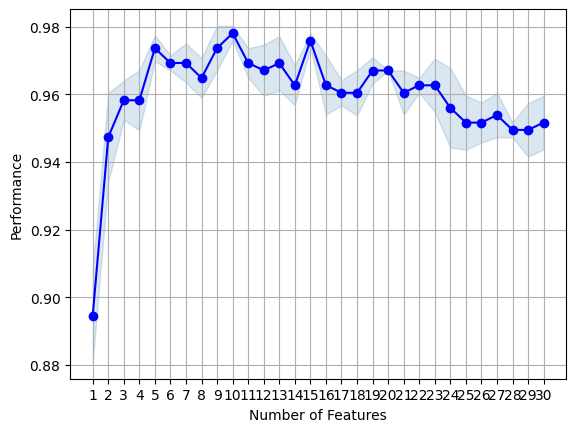

In [16]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

plot_sfs(forward.get_metric_dict(), kind='std_err')
plt.grid()

> Backward Elimination

In [17]:
backward = SFS(
    estimator = RandomForestClassifier(n_estimators=5, n_jobs=-1, random_state=0),
    k_features = 'best',
    forward=False,
    floating=False,
    verbose=1,
    scoring='accuracy',
    cv=3
)

backward = backward.fit(np.array(X_train), y_train)

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.2s finished
Features: 29/1[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    3.0s finished
Features: 28/1[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    2.9s finished
Features: 27/1[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    3.4s finished
Features: 26/1[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    2.7s finished
Features: 25/1[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    2.5s finished
Features: 24/1[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    2.4s finished
Features: 23/1[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    2.8s finished
Features: 22/1[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    2.3s finished
Features: 21/1[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    2.1s finished
Features: 20/1[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.0s finished
Features: 19/1[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.9s finished
Featur

In [18]:
selector_backward = X_train.columns[list(forward.k_feature_idx_)]
selector_backward

Index(['mean texture', 'mean concave points', 'concave points error',
       'worst radius', 'worst texture', 'worst area', 'worst smoothness',
       'worst concavity', 'worst concave points', 'worst fractal dimension'],
      dtype='object')

In [19]:
pd.DataFrame.from_dict(backward.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
30,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.9407894736842105, 0.9671052631578947, 0.947...",0.951638,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.025268,0.011229,0.00794
29,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14,...","[0.9605263157894737, 0.9407894736842105, 0.966...",0.956068,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14,...",0.025004,0.011111,0.007857
28,"(0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15...","[0.9473684210526315, 0.9802631578947368, 0.960...",0.962632,"(0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15...",0.030454,0.013533,0.009569
27,"(0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 14, 15, 1...","[0.9671052631578947, 0.9671052631578947, 0.953...",0.962618,"(0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 14, 15, 1...",0.014282,0.006346,0.004488
26,"(0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 14, 15, 1...","[0.9407894736842105, 0.9671052631578947, 0.973...",0.960468,"(0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 14, 15, 1...",0.031861,0.014159,0.010012
25,"(0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 14, 15, 1...","[0.9473684210526315, 0.9671052631578947, 0.966...",0.960454,"(0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 14, 15, 1...",0.020823,0.009253,0.006543
24,"(0, 1, 2, 4, 7, 8, 9, 10, 11, 12, 14, 15, 16, ...","[0.9736842105263158, 0.9605263157894737, 0.960...",0.964825,"(0, 1, 2, 4, 7, 8, 9, 10, 11, 12, 14, 15, 16, ...",0.014099,0.006265,0.00443
23,"(0, 1, 2, 4, 7, 9, 10, 11, 12, 14, 15, 16, 17,...","[0.9473684210526315, 0.9671052631578947, 0.960...",0.958246,"(0, 1, 2, 4, 7, 9, 10, 11, 12, 14, 15, 16, 17,...",0.018414,0.008183,0.005786
22,"(0, 1, 2, 4, 7, 9, 10, 11, 12, 14, 15, 16, 17,...","[0.9605263157894737, 0.9473684210526315, 0.966...",0.958261,"(0, 1, 2, 4, 7, 9, 10, 11, 12, 14, 15, 16, 17,...",0.018291,0.008128,0.005747
21,"(0, 1, 2, 4, 7, 9, 10, 11, 12, 14, 15, 16, 18,...","[0.9605263157894737, 0.9539473684210527, 0.953...",0.956039,"(0, 1, 2, 4, 7, 9, 10, 11, 12, 14, 15, 16, 18,...",0.007146,0.003176,0.002246


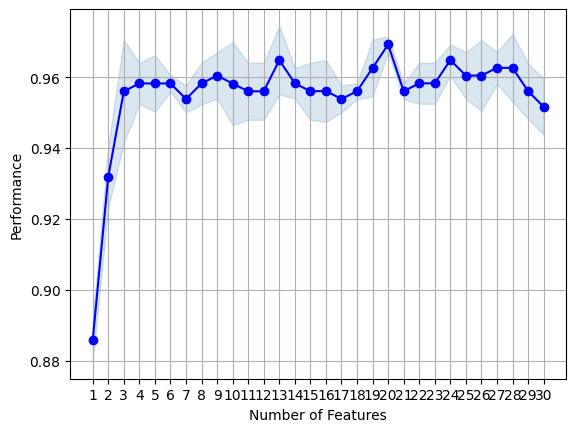

In [20]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

plot_sfs(backward.get_metric_dict(), kind='std_err')
plt.grid()

> Exhaustive Feature Selection

In [21]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

exhaust = EFS(
    estimator=RandomForestClassifier(n_estimators=5, n_jobs=-1, random_state=0),
    min_features=2,
    max_features=2,
    n_jobs= -1,
    scoring = 'accuracy',
    cv=3
)

exahust = exhaust.fit(np.array(X_train), y_train)

Features: 435/435

In [22]:
pd.DataFrame.from_dict(exhaust.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
0,"(0, 1)","[0.8552631578947368, 0.8552631578947368, 0.880...",0.863774,"(0, 1)",0.027084,0.012036,0.008511
1,"(0, 2)","[0.8223684210526315, 0.868421052631579, 0.8741...",0.854987,"(0, 2)",0.052172,0.023184,0.016394
2,"(0, 3)","[0.8881578947368421, 0.881578947368421, 0.8410...",0.870265,"(0, 3)",0.046864,0.020826,0.014726
3,"(0, 4)","[0.9013157894736842, 0.8618421052631579, 0.834...",0.865865,"(0, 4)",0.061774,0.027451,0.019411
4,"(0, 5)","[0.8881578947368421, 0.9144736842105263, 0.874...",0.892268,"(0, 5)",0.037598,0.016708,0.011814
...,...,...,...,...,...,...,...
430,"(26, 28)","[0.8092105263157895, 0.8289473684210527, 0.854...",0.830821,"(26, 28)",0.041535,0.018457,0.013051
431,"(26, 29)","[0.7894736842105263, 0.8486842105263158, 0.907...",0.848481,"(26, 29)",0.108233,0.048096,0.034009
432,"(27, 28)","[0.8881578947368421, 0.9013157894736842, 0.933...",0.90775,"(27, 28)",0.04314,0.019171,0.013556
433,"(27, 29)","[0.8947368421052632, 0.9013157894736842, 0.933...",0.909942,"(27, 29)",0.038401,0.017065,0.012067


#### **Model Based Feature Selection / Embedded Method**

Embedded Method combine the advantages of the filter and wrapper methods. A learning algorithm takes advantage of its own variable selection process and performs feature selection and classification at same time. Common embedded methods include Lasso and various types of tree-based algorithms. It is featured as:

- perform feature selection as part of the model building process
- consider interactions between features
- less computationally expensive as it only train the model once, compared to Wrappers
- usually provide the best performing subset for a give ML algorithm, but probably not for another

##### **Regularization with Lasso**

Lasso Regularization is commonly used as a feture selection criterion. It penalizes irrelevant parameters by shrinking their weights or coefficients to zero. Hence, those features are removed from the model, and it not only removes the extraneous features and prevents the model from overfitting. One can learn the complete working of regularization in [here](https://www.enjoyalgorithms.com/blog/regularization-in-machine-learning).

##### **Random Forest Feature Importance**

The tree based model approach naturally ranks the feature of a dataset by measuring how well the purity is improving. The measure of impurity is either the Gini impurity or the information gain/entropy. When training a tree, it is possible to compute how much each feature decreases the impurity. The more a feature decreases the impurity, the more important the feature is. In random forests, the impurity decrease from each feature can be averaged across trees to determine the final importance of the variable.

In [23]:
from sklearn.feature_selection import SelectFromModel

> L1 Regularization

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler

# preprocessing
scaler = RobustScaler()
scaler.fit(X_train)

X_train_scale = scaler.transform(X_train)

# feature selection
embed_lasso = SelectFromModel(LogisticRegression(solver='liblinear', C=1, penalty='l1')) # l1: lasso
embed_lasso.fit(X_train_scale, y_train)

# selected feature
selected_feature = X_train.columns[(embed_lasso.get_support())]
selected_feature

Index(['mean texture', 'mean concavity', 'mean concave points',
       'mean fractal dimension', 'radius error', 'area error',
       'smoothness error', 'compactness error', 'symmetry error',
       'worst radius', 'worst texture', 'worst area', 'worst smoothness',
       'worst concavity', 'worst concave points', 'worst symmetry'],
      dtype='object')

> RF Feature Importances

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler

# feature selection
embed_rf = SelectFromModel(RandomForestClassifier()) # l1: lasso
embed_rf.fit(X_train_scale, y_train)

# selected feature
selected_feature = X_train.columns[(embed_lasso.get_support())]
selected_feature

Index(['mean texture', 'mean concavity', 'mean concave points',
       'mean fractal dimension', 'radius error', 'area error',
       'smoothness error', 'compactness error', 'symmetry error',
       'worst radius', 'worst texture', 'worst area', 'worst smoothness',
       'worst concavity', 'worst concave points', 'worst symmetry'],
      dtype='object')

### `Application`

`Load Dataset`


In [26]:
# Load dataset
white_wine_csv = 'https://raw.githubusercontent.com/harishmuh/machine_learning_practices/refs/heads/main/datasets/white_wine.csv'
wine = pd.read_csv(white_wine_csv )
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0


`Data Cleaning`

**Duplicated Value**

Duplicated data detection and quantification

In [27]:
print(f'Total number of duplicates: {wine.duplicated().sum()}')
print(f'Total duplicate percentage: {wine.duplicated().sum()/len(wine)*100:.2f}%')

Total number of duplicates: 84
Total duplicate percentage: 16.15%


As much as 16.15% of the data is indicated as duplicate, so remove one of them.

Handling duplicates

In [28]:
wine.drop_duplicates(inplace=True)

**Missing Value**

Missing value detection and quantification

In [30]:
wine.isna().sum().to_frame('missing_value')

,missing_value
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,1
sulphates,1


There are missing values ​​in the pH, sulphates, alcohol and quality columns. We will just drop the missing value.

In [31]:
wine.dropna(inplace=True)

**Change Target**

Change the target to binary categorical.

In [32]:
wine['quality'] = np.where(wine['quality']>6, 1, 0) # Good quality wine: 1, Poor quality wine: 0
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,0


`Data Splitting`

Divide the dataset into train and test sets with a composition of 80:20.

In [33]:
# define feature and target
X = wine.drop(columns=['quality'])
y = wine['quality']

# separating data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

`Data Preprocessing`

Next we will do preprocessing as follows:

In [34]:
selector_kbest = SelectKBest(chi2, k=5)
selector_percentile = SelectPercentile(mutual_info_classif, percentile=25)
selector_embed = SelectFromModel(LogisticRegression(solver='liblinear', C=1, penalty='l1'))

selectors = [None, selector_kbest, selector_percentile, selector_embed]

### `Modeling`

In [35]:
# Pipeline
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline


names = []
scores = []
features = []

for selector in selectors:

    # define modeling pipeline
    clf = Pipeline([
        ('feature selection', selector),
        ('modeling', LogisticRegression())
    ])

    # fitting
    clf.fit(X_train, y_train)

    # predict to test set
    y_pred = clf.predict(X_test)

    # evaluation
    score = accuracy_score(y_test, y_pred)

    scores.append(score)
    names.append(selector.__class__.__name__)

    if selector == None:
        features.append(['all'])
    else:
        features.append(selector.get_feature_names_out())

In [36]:
pd.set_option('display.max_colwidth', None)

pd.DataFrame({
    'method': names,
    'accuracy': scores,
    'selected features': features
})


,method,accuracy,selected features
0,NoneType,0.873563,[all]
1,SelectKBest,0.873563,"[fixed acidity, residual sugar, free sulfur dioxide, total sulfur dioxide, alcohol]"
2,SelectPercentile,0.885057,"[chlorides, density, alcohol]"
3,SelectFromModel,0.885057,"[fixed acidity, volatile acidity, residual sugar, free sulfur dioxide, total sulfur dioxide, pH, alcohol]"
